In [50]:
import yfinance as yf
import numpy as np
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from deep_translator import GoogleTranslator
import seaborn as sns

In [38]:
CryptoTicket = ["BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "ADA-USD", "DOGE-USD"]

In [39]:
crypto_data = yf.download(CryptoTicket, start="2020-01-01", end="2024-12-30")['Adj Close']
crypto_data = crypto_data.dropna()
crypto_returns = np.log(crypto_data / crypto_data.shift(1)).dropna()

[*********************100%***********************]  6 of 6 completed


In [40]:
crypto_news = [
    "BlackRock's Bitcoin Fund Became 'Greatest Launch in ETF History'",
    "MicroStrategy Buys $209 Million of Bitcoin as purchases lessen",
    "Trump's 'Made in USA' Bitcoin is Proomise Impossible to keep",
    "Bitcoin falls with Record-Breaking Year Beginning to wind Down",
    "Bitcoin Rally fueled by Trump Loses Steam as Year Draws to Close",
    "Bitcoin Drops to $92.000 as Long-Term Holders Keep Taking profit",
    "XRP sinks 5% to lead Crypto Losses as Strong Dollar Rattles Bitcoin Bulls",
    "Ethereum NFT trading Volumen Reaches $106 Million, Boosted by Pudgy Pengui's $PENGU token launch"
]

In [41]:
sentiments_blob = [TextBlob(news).sentiment.polarity for news in crypto_news]

analyzer = SentimentIntensityAnalyzer()
sentiments_vader = [analyzer.polarity_scores(news)['compound'] for news in crypto_news]

translated_news = [GoogleTranslator(source='en', target='es').translate(news) for news in crypto_news]

sentiments_df = pd.DataFrame({
    "News": crypto_news,
    "Translated News": translated_news,
    "TextBlob Sentiment": sentiments_blob,
    "VADER Sentiment": sentiments_vader
})
print("Resultados del análisis de sentimiento:\n", sentiments_df)

Resultados del análisis de sentimiento:
                                                 News  \
0  BlackRock's Bitcoin Fund Became 'Greatest Laun...   
1  MicroStrategy Buys $209 Million of Bitcoin as ...   
2  Trump's 'Made in USA' Bitcoin is Proomise Impo...   
3  Bitcoin falls with Record-Breaking Year Beginn...   
4  Bitcoin Rally fueled by Trump Loses Steam as Y...   
5  Bitcoin Drops to $92.000 as Long-Term Holders ...   
6  XRP sinks 5% to lead Crypto Losses as Strong D...   
7  Ethereum NFT trading Volumen Reaches $106 Mill...   

                                     Translated News  TextBlob Sentiment  \
0  El fondo Bitcoin de BlackRock se convirtió en ...            1.000000   
1  MicroStrategy compra 209 millones de dólares e...            0.000000   
2  El Bitcoin "Made in USA" de Trump promete ser ...           -0.666667   
3  Bitcoin cae y el año récord comienza a llegar ...           -0.155556   
4  El rally de Bitcoin impulsado por Trump pierde...           -0.300000  

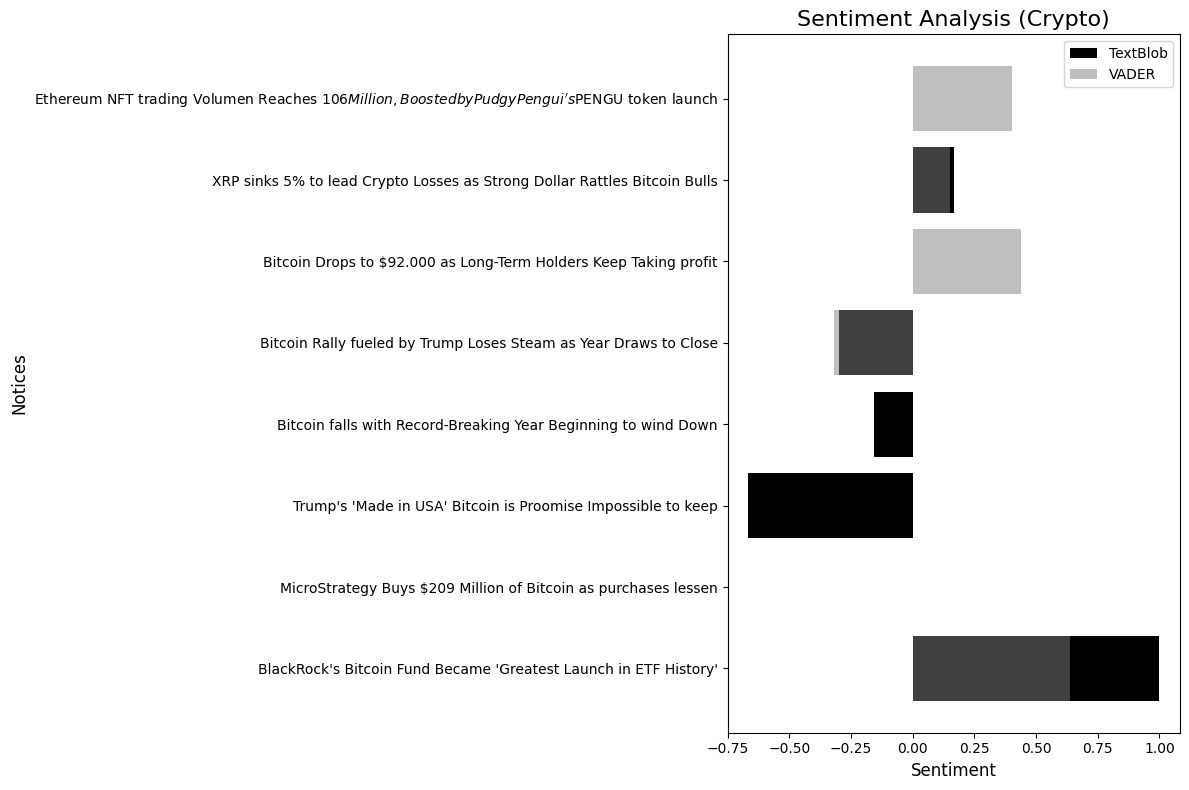

In [42]:
plt.figure(figsize=(12, 8))
plt.barh(sentiments_df['News'], sentiments_df['TextBlob Sentiment'], color='black', label='TextBlob')
plt.barh(sentiments_df['News'], sentiments_df['VADER Sentiment'], color='gray', alpha=0.5, label='VADER')
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Notices", fontsize=12)
plt.title("Sentiment Analysis (Crypto)", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
def classify_sentiment(polarity):
    if polarity > 0.2:
        return "Positive"
    elif polarity < -0.2:
        return "Negative"
    else:
        return "Neutral"

sentiments_df['Sentiment Category'] = sentiments_df['TextBlob Sentiment'].apply(classify_sentiment)
print("Noticias clasificadas por sentimiento:\n", sentiments_df[['News', 'Sentiment Category']])



Noticias clasificadas por sentimiento:
                                                 News Sentiment Category
0  BlackRock's Bitcoin Fund Became 'Greatest Laun...           Positive
1  MicroStrategy Buys $209 Million of Bitcoin as ...            Neutral
2  Trump's 'Made in USA' Bitcoin is Proomise Impo...           Negative
3  Bitcoin falls with Record-Breaking Year Beginn...            Neutral
4  Bitcoin Rally fueled by Trump Loses Steam as Y...           Negative
5  Bitcoin Drops to $92.000 as Long-Term Holders ...            Neutral
6  XRP sinks 5% to lead Crypto Losses as Strong D...            Neutral
7  Ethereum NFT trading Volumen Reaches $106 Mill...            Neutral


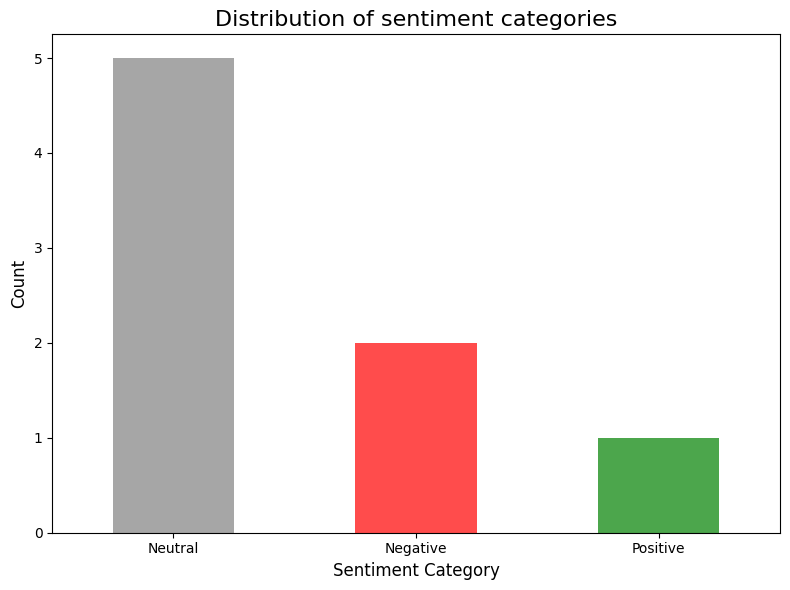

In [48]:
category_counts = sentiments_df['Sentiment Category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['gray', 'red', 'green'], alpha=0.7)
plt.title("Distribution of sentiment categories", fontsize=16)
plt.xlabel("Sentiment Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

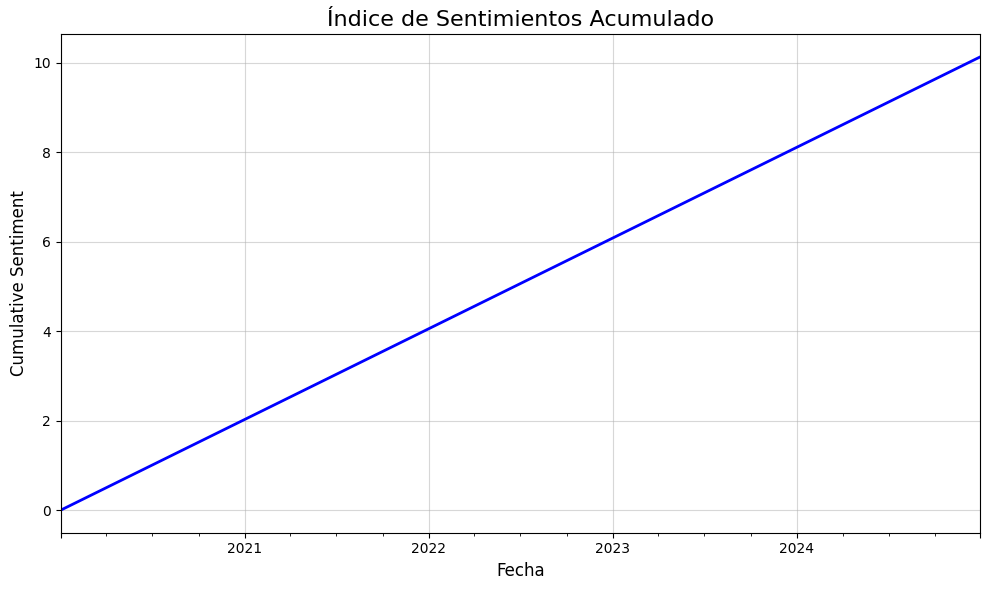

In [45]:
average_sentiment = np.mean(sentiments_blob)
crypto_returns['Average Sentiment'] = average_sentiment
crypto_returns['Cumulative Sentiment'] = crypto_returns['Average Sentiment'].cumsum()

# Graficar el índice de sentimiento acumulado
plt.figure(figsize=(10, 6))
crypto_returns['Cumulative Sentiment'].plot(color='blue', lw=2)
plt.title("Índice de Sentimientos Acumulado", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Cumulative Sentiment", fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [46]:
X = sentiments_df[['TextBlob Sentiment', 'VADER Sentiment']].values
y = crypto_returns['BTC-USD'][:len(X)].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

latest_price = crypto_data['BTC-USD'].iloc[-1]
predicted_prices = latest_price * np.exp(predictions)

print("Predicciones de precios basadas en sentimientos (en USD):", predicted_prices[:5])

Predicciones de precios basadas en sentimientos (en USD): [93097.37420707 91563.10409382]


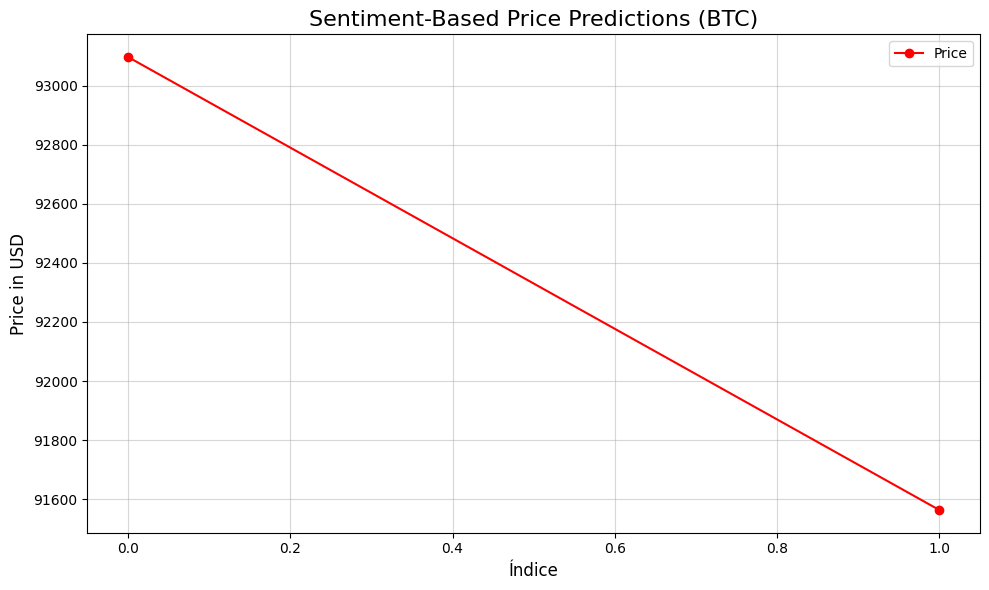

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_prices, label='Price', marker='o', color='red')
plt.title("Sentiment-Based Price Predictions (BTC)", fontsize=16)
plt.xlabel("Índice", fontsize=12)
plt.ylabel("Price in USD", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()
